## Raman SV - Data 512 - Part 1 - Common Analysis

Snippets of code in this document are either used as is or modified based on the example code shared by Dr. David McDonald, professor for Data 512

These are from the notebooks shared as part of the starter code for this assignment

These are licensed CC-BY (https://creativecommons.org/licenses/by/4.0/) by the original author

This entire notebook along with the datasources are licensed CC-BY (https://creativecommons.org/licenses/by/4.0/)

In [40]:
# Import the necessary libraries
import json
from pyproj import Transformer, Geod

# Install statements if required
#!pip install geopandas folium
#!pip install geopy

import geojson
from tqdm import tqdm
import pandas as pd
import os
import folium
import geopy
import numpy as np
import matplotlib.pyplot as plt

import time
import requests
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


In [12]:
# CONSTANTS

EXTRACT_FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"
FILENAME = r'C:\Users\raman\OneDrive\Desktop\UDubs\Classroom\Q4\Data 512 - HCDS\Assignments\Part 1 - Common Analysis\Data\GeoJSON Exports\USGS_Wildland_Fire_Combined_Dataset.json'

# print out where we think we're going to find the sample data
print(f"{FILENAME=}")

CITY_LOCATION = {
    'Bozeman': {'city': 'Bozeman',
                 'latlon': [45.6793, -111.0373] }
}



FILENAME='C:\\Users\\raman\\OneDrive\\Desktop\\UDubs\\Classroom\\Q4\\Data 512 - HCDS\\Assignments\\Part 1 - Common Analysis\\Data\\GeoJSON Exports\\USGS_Wildland_Fire_Combined_Dataset.json'


In [ ]:
#    Open a file, load it with the geojson loader
#
print(f"Attempting to open '{FILENAME}'")
with open(FILENAME,"r") as f:
    gj_data = geojson.load(f)


In [ ]:
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()

In [13]:
#    Transform feature geometry data
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [14]:
##    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point


In [ ]:
#    Get a city from our CITY_LOCATIONS constant as our starting position
place = CITY_LOCATION["Bozeman"]
attributes_list = []
count_curveRings = 0

for feature in tqdm(gj_data['features']):
    try:
        wf_year = feature['attributes']['Fire_Year']
        if 1963 <= wf_year <= 2023:
            ring_data = feature['geometry']['rings'][0]

        #   Compute using the shortest distance to any point on the perimeter
            distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)

            if distance[0] <= 1250.00:
                feature_attributes = feature['attributes']
                feature_attributes['Distance'] = distance[0]
                attributes_list.append(feature_attributes)
    except Exception as e:
        count_curveRings += 1

print(f"Number of curveRings : {count_curveRings}")


# Create a DataFrame from the list of feature dictionaries
df = pd.DataFrame(attributes_list)


In [ ]:
df.to_csv('\interim data\all_fire_data_with_distance_rs.csv', index=False)

In [7]:
# Getting data from the csv in case the kernel is reset

#df = pd.read_csv('\interim data\all_fire_data_with_distance_rs.csv')
df = pd.read_csv('../Interim Data/all_fire_data_with_distance_rs.csv')

# Add number of fires per year
num_fires = df.groupby("Fire_Year").size().reset_index(name="Fires_this_year")
df = df.merge(num_fires, on="Fire_Year", how="left")


C:\Users\raman\AppData\Local\Temp\ipykernel_548\2930487355.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Interim Data/all_fire_data_with_distance_rs.csv')


# Fiercity Scoring

The below set of cells create a category mapping for some columns deemed significant enough to affect Air Quality
Throughout this set, higher the value, higher the impact


Scoring for Wildfire types

In [8]:
# Create the mapping for scoring
fire_type_mapping = {
    "Wildfire": 1,
    "Unknown - Likely Wildfire": 4,
    "Prescribed Fire": 3,
    "Likely Wildfire": 2,
    "Unknown - Likely Prescribed Fire": 5,
}

# Add values in the rating column
df["Fire_Type_Rating"] = df["Assigned_Fire_Type"].map(fire_type_mapping)



Create quintiles for GIS_Hectares and assign highest rating to the ones with the highest values

In [9]:
# Calculate quintiles
quintiles = pd.qcut(df["GIS_Hectares"], q=5, labels=False)

# Define ratings
ratings = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}

# Add values in the rating column
df["Hectares_Quintile_Rating"] = quintiles.map(ratings)


Create quintiles for Shape_Area and assign highest rating to the ones with the highest values

In [10]:
# Calculate quintiles
quintiles = pd.qcut(df["Shape_Area"], q=5, labels=False)

# Define ratings
ratings = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}

# Add values in the rating column
df["Shape_Area__Quintile_Rating"] = quintiles.map(ratings)


Create quintiles for number of fires and assign highest rating to the ones with the highest values

In [11]:
# Calculate quintiles
quintiles = pd.qcut(df["Fires_this_year"], q=5, labels=False)

# Define ratings
ratings = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}

# Add values in the rating column
df["Fires_this_year_Quintile_Rating"] = quintiles.map(ratings)


Create ratings based on proximity to fire 

In [12]:
# Create distance mappings
conditions = [
    df["Distance"] < 100,
    (df["Distance"] >= 100) & (df["Distance"] < 250),
    (df["Distance"] >= 250) & (df["Distance"] < 500),
    (df["Distance"] >= 500) & (df["Distance"] < 750),
]
ratings = [5, 4, 3, 2]

# Add values in the rating column
df["Distance_Rating"] = np.select(conditions, ratings, 1)



Create ratings based on circleness score 

In [13]:
# Calculate quintiles
quintiles = pd.qcut(df["Circleness_Scale"], q=5, labels=False)

# Define ratings
ratings = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}

# Add values in the rating column
df["Circleness_Scale_Quintile_Rating"] = quintiles.map(ratings)


In [68]:
df.head(5)

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Shape_Length,Shape_Area,Distance,Fires_this_year,Fire_Type_Rating,Hectares_Quintile_Rating,Shape_Area__Quintile_Rating,Fires_this_year_Quintile_Rating,Distance_Rating,Circleness_Scale_Quintile_Rating
0,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,73550.428118,1.658906e+08,285.409554,378,1,5,5,1,3,3
1,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,59920.576713,1.042352e+08,303.805923,378,1,5,5,1,3,2
2,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,84936.827810,1.842421e+08,272.984951,378,1,5,5,1,3,2
3,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,35105.903602,4.206711e+07,286.335114,378,1,5,5,1,3,3
4,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,26870.456126,4.040222e+07,280.834097,378,1,5,5,1,3,4


To get the final rating, use a weighted scaled to sum up for each row and then aggregate by year

In [14]:
# Create necessary weights
weight_fire_type = 0.05
weight_hectares = 0.15
weight_shape_area = 0.15
weight_distance = 0.35
weight_circle = 0.3

# Calculate the weighted scores
df["Fiercity_Score"] = (
    df["Fire_Type_Rating"] * weight_fire_type +
    df["Hectares_Quintile_Rating"] * weight_hectares +
    df["Shape_Area__Quintile_Rating"] * weight_shape_area +
    df["Distance_Rating"] * weight_distance +
    df["Circleness_Scale_Quintile_Rating"] * weight_circle
)

Fire_scores_df = df.copy()
# Create an analysis df that groups the scores and number of fires by year
result = df.groupby("Fire_Year")["Fiercity_Score"].agg(['mean', 'count']).reset_index()

result = result.rename(columns={"mean": "Total_Fiercity_Score", "count": "Fires_this_year_2"})
result["Total_Fiercity_Score_for_all_fires"] = result["Total_Fiercity_Score"] * result["Fires_this_year_2"]
# Adding a rank to compare with the AQI ranks
result['Fiercity_Rank'] = result['Total_Fiercity_Score_for_all_fires'].rank(ascending=False, method='min')


In [77]:
# Save the above file for further processing if needed
#df.to_csv('Fire_ratings_2.csv', index=False)
#df.to_excel('Fire_ratings.xlsx', index=False)
result.to_excel('Final_ratings_5.xlsx', index=False)

## AQI Scores

In [16]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



In [17]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In [18]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
# print("Requesting SIGNUP ...")
# response = request_signup("svraman@uw.edu")
# print(json.dumps(response,indent=4))
#
#
#   You can specify these as constants for your own use
#
USERNAME = "svraman@uw.edu"
APIKEY = ""


In [19]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [20]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

print(request_data['email'])
print(request_data['key'])

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


svraman@uw.edu
dunhare32
[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE

In [21]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [22]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor. 

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

What I did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [23]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

Air quality monitoring stations are located all over the US at different locations. We will need some sample locations to experiment with different locations to see what kinds of values come back from different sensor requests.

This list includes the [FIPS](https://www.census.gov/library/reference/code-lists/ansi.html) number for the state and county as a 5 digit string. This format, the 5 digit string, is a 'old' format that is still widely used. There are new codes that may eventually be adopted for the US government information systems. But FIPS is currently what the AQS uses, so that's what is in the list as the constant.

Just two example cities to explore.

In [24]:
#
#   We'll use these two city locations in the examples below.
#
CITY_LOCATIONS = {
    'Bozeman' :       {'city'   : 'Bozeman',
                       'county' : 'Gallatin',
                       'state'  : 'Montana',
                       'fips'   : '30031',
                       'latlon' : [45.6793, -111.0373] }
}


Given our CITY_LOCATIONS constant we can now find which monitoring locations are nearby. One option is to use the county to define the area we're interest in. You can get the EPA to list their monitoring stations by county. You can also get a set of monitoring stations by using a bounding box of latitude, longitude points. For this example, we'll use the county approach. There is a bounding box example later in this notebook.

In [25]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['Bozeman']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['Bozeman']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": "Bozeman  WWTP"
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": "Belgrade Conagra"
    },
    {
        "code": "0009",
        "value_represented": "US HWY 191, YELLOWSTONE NAT'L PARK WEST ENTRANCE"
    },
    {
        "code": "0012",
        "value_represented": "OPEN LOT CORNER OF FIREHOLE & DUNRAVEN, W YLLSTN"
    },
    {
        "code": "0013",
        "value_represented": "West Yellowstone Park Ent"
    },
    {
        "code": "0014",
        "value_represented": "ON A RECLAIMED CE

In [26]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [27]:

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['Bozeman']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['Bozeman']['fips'][2:]

# request daily summary data for the month of July in 2021
gaseous_aqi = request_daily_summary(request_template=request_data, begin_date="20210701", end_date="20210731")
print("Response for the gaseous pollutants ...")
#
if gaseous_aqi["Header"][0]['status'] == "Success":
    print(json.dumps(gaseous_aqi['Data'],indent=4))
elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
else:
    print(json.dumps(gaseous_aqi,indent=4))

request_data['param'] = AQI_PARAMS_PARTICULATES
# request daily summary data for the month of July in 2021
particulate_aqi = request_daily_summary(request_template=request_data, begin_date="20210701", end_date="20210731")
print("Response for the particulate pollutants ...")
#
if particulate_aqi["Header"][0]['status'] == "Success":
    print(json.dumps(particulate_aqi['Data'],indent=4))
elif particulate_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
else:
    print(json.dumps(particulate_aqi,indent=4))


Response for the gaseous pollutants ...
[
    {
        "state_code": "30",
        "county_code": "031",
        "site_number": "0017",
        "parameter_code": "42602",
        "poc": 5,
        "latitude": 44.657014,
        "longitude": -111.089618,
        "datum": "WGS84",
        "parameter": "Nitrogen dioxide (NO2)",
        "sample_duration_code": "1",
        "sample_duration": "1 HOUR",
        "pollutant_standard": "NO2 1-hour 2010",
        "date_local": "2021-07-01",
        "units_of_measure": "Parts per billion",
        "event_type": "Events Included",
        "observation_count": 23,
        "observation_percent": 96.0,
        "validity_indicator": "Y",
        "arithmetic_mean": 1.865217,
        "first_max_value": 8.1,
        "first_max_hour": 5,
        "aqi": 8,
        "method_code": "599",
        "method": "Instrumental - Chemiluminescence Teledyne API 200 EU/501",
        "local_site_name": "West Yellowstone Park Ent #2",
        "site_address": "NE of West

In [28]:
#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


Create a code to iterate through all the years, one at a time

In [29]:
start_year = 1963
end_year = 2023
all_gaseous_responses = []
all_particulate_responses = []

# Iterate for all the years
for year in range(start_year, end_year + 1):
    # Modify the request_data with the current year
    request_data = AQS_REQUEST_TEMPLATE.copy()
    request_data['email'] = USERNAME
    request_data['key'] = APIKEY
    request_data['state'] = CITY_LOCATIONS['Bozeman']['fips'][:2]
    request_data['county'] = CITY_LOCATIONS['Bozeman']['fips'][2:]

    start_date = f"{year}0101"
    end_date = f"{year}1231"

    # Summary for gaseous pollutants
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=end_date)

    # Append the response
    if gaseous_aqi["Header"][0]['status'] == "Success":
        gaseous_aqi_2 = extract_summary_from_response(gaseous_aqi)
        all_gaseous_responses.append(gaseous_aqi_2)

    elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
        print(f"No gaseous data available for {year}.")

    else:
        print(f"Error in retrieving data for {year}.")

    # Summary for particulate pollutants
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=end_date)

    # Append the response
    if particulate_aqi["Header"][0]['status'] == "Success":
        particulate_aqi_2 = extract_summary_from_response(particulate_aqi)
        all_particulate_responses.append(particulate_aqi_2)

    elif particulate_aqi["Header"][0]['status'].startswith("No data "):
        print(f"No particulate data available for {year}.")

    else:
        print(f"Error in retrieving data for {year}.")



No gaseous data available for 1963.
No particulate data available for 1963.
No gaseous data available for 1964.
No particulate data available for 1964.
No gaseous data available for 1965.
No particulate data available for 1965.
No gaseous data available for 1966.
No particulate data available for 1966.
No gaseous data available for 1967.
No particulate data available for 1967.
No gaseous data available for 1968.
No particulate data available for 1968.
No gaseous data available for 1969.
No particulate data available for 1969.
No gaseous data available for 1970.
No particulate data available for 1970.
No gaseous data available for 1971.
No particulate data available for 1971.
No gaseous data available for 1972.
No particulate data available for 1972.
No gaseous data available for 1973.
No particulate data available for 1973.
No gaseous data available for 1974.
No particulate data available for 1974.
No gaseous data available for 1975.
No particulate data available for 1975.
No gaseous d

In [30]:
# Saving the data for processing and as a savepoint

output_file = "Interim Data/particulate_data.json"

# Write the JSON data to the text file with an indentation of 4
with open(output_file, 'w') as file:
    json.dump(all_particulate_responses, file, indent=4)

output_file = "Interim Data/gaseous_data.json"

# Write the JSON data to the text file with an indentation of 4
with open(output_file, 'w') as file:
    json.dump(all_gaseous_responses, file, indent=4)


FileNotFoundError: [Errno 2] No such file or directory: 'Interim Data/particulate_data.json'

In [31]:
def extract_aqi(data, dynamic_keys=None):
    if dynamic_keys is None:
        dynamic_keys = []

    extracted_data = []

    for key, value in data.items():
        current_keys = dynamic_keys + [key]

        if isinstance(value, dict):
            extracted_data.extend(extract_aqi(value, current_keys))
        elif isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    aqi = item.get("aqi")
                    sample_duration = item.get("sample_duration")
                    if aqi is not None:
                        extracted_data.append({"keys": current_keys,"sample_duration": sample_duration, "aqi": aqi})

    return extracted_data

In [32]:
# Initialize a list to store the extracted data
gaseous_extract = []

for dataset in all_gaseous_responses:
    gaseous_extract.extend(extract_aqi(dataset))

# Print or further process the extracted data
for entry in gaseous_extract:
    keys = " > ".join(entry["keys"])
    aqi = entry["aqi"]
    sample = entry['sample_duration']
    #print(f"Keys: {keys}, AQI: {aqi} , SAMPLE: {sample}")

particulate_extract = []

for dataset in all_particulate_responses:
    particulate_extract.extend(extract_aqi(dataset))

# Print or further process the extracted data
for entry in particulate_extract:
    keys = " > ".join(entry["keys"])
    aqi = entry["aqi"]
    sample = entry['sample_duration']
    #print(f"Keys: {keys}, AQI: {aqi} , SAMPLE: {sample}")



In [33]:
# Extract relevant information and create a new list of dictionaries
df_formatted = []

for entry in particulate_extract:
    keys = entry['keys']
    date = keys[-1]
    aqi = entry['aqi']
    sample_duration = entry['sample_duration']
    pollutant_type = keys[-3]

    df_formatted.append({'Date': date, 'AQI': aqi, 'Sample_Duration': sample_duration, 'Pollutant_Type': pollutant_type})

# Create a DataFrame from the formatted data
particulate_df = pd.DataFrame(df_formatted)

# Convert the 'Date' column to a datetime format
particulate_df['Date'] = pd.to_datetime(particulate_df['Date'], format='%Y%m%d')

# Caclulate the max for each date and remove the sample and pollutant type columns 
particulate_df = particulate_df.drop(['Sample_Duration', 'Pollutant_Type'], axis=1)
particulate_df = particulate_df.groupby('Date', as_index=False).agg({'AQI': 'max'})

particulate_df.head(10)

,Date,AQI
0,1985-07-18,35
1,1985-10-04,38
2,1985-10-16,48
3,1985-10-22,23
4,1985-10-28,55
5,1985-11-03,31
6,1986-03-15,21
7,1986-03-27,51
8,1986-04-08,34
9,1986-05-02,44


In [34]:
# Extract relevant information and create a new list of dictionaries
df_formatted = []

for entry in gaseous_extract:
    keys = entry['keys']
    date = keys[-1]
    aqi = entry['aqi']
    sample_duration = entry['sample_duration']
    pollutant_type = keys[-3]

    df_formatted.append({'Date': date, 'AQI': aqi, 'Sample_Duration': sample_duration, 'Pollutant_Type': pollutant_type})

# Create a DataFrame from the formatted data
gaseous_df = pd.DataFrame(df_formatted)

# Convert the 'Date' column to a datetime format
gaseous_df['Date'] = pd.to_datetime(gaseous_df['Date'], format='%Y%m%d')

# Caclulate the max for each date and remove the sample and pollutant type columns 
gaseous_df = gaseous_df.drop(['Sample_Duration', 'Pollutant_Type'], axis=1)
gaseous_df = gaseous_df.groupby('Date', as_index=False).agg({'AQI': 'max'})

gaseous_df.head(10)



,Date,AQI
0,1998-10-22,2
1,1998-10-23,1
2,1998-10-24,2
3,1998-10-25,1
4,1998-10-26,1
5,1998-10-27,2
6,1998-10-28,1
7,1998-10-29,0
8,1998-10-30,0
9,1998-10-31,1


Merge the gaseous and pollutant dataset to get 1 value per day, which will be the max value

In [35]:

AQI_df = particulate_df.merge(gaseous_df, on='Date', how='outer', suffixes=('_gas', '_part'))
AQI_df['AQI'] = AQI_df[['AQI_gas', 'AQI_part']].max(axis=1)

AQI_df['AQI'].fillna(AQI_df['AQI_gas'].combine_first(AQI_df['AQI_part']), inplace=True)
AQI_df.drop(columns=['AQI_gas', 'AQI_part'], inplace=True)

# Extract the year from the 'Date' column
AQI_df['Year'] = AQI_df['Date'].dt.year
AQI_df.head(10)

,Date,AQI,Year
0,1985-07-18,35.0,1985
1,1985-10-04,38.0,1985
2,1985-10-16,48.0,1985
3,1985-10-22,23.0,1985
4,1985-10-28,55.0,1985
5,1985-11-03,31.0,1985
6,1986-03-15,21.0,1986
7,1986-03-27,51.0,1986
8,1986-04-08,34.0,1986
9,1986-05-02,44.0,1986


In [36]:
# date_filtered = (AQI_df['Date'].dt.month >= 5) & (AQI_df['Date'].dt.month <= 10)
#AQI_df = AQI_df[date_filtered]

# For each year, get these stats
AQI_by_year = AQI_df.groupby('Year').agg(
    Min_AQI=pd.NamedAgg(column='AQI', aggfunc='min'),
    Max_AQI=pd.NamedAgg(column='AQI', aggfunc='max'),
    Median_AQI=pd.NamedAgg(column='AQI', aggfunc='median'),
    Avg_AQI=pd.NamedAgg(column='AQI', aggfunc='mean'),
    Mode_AQI=pd.NamedAgg(column='AQI', aggfunc=lambda x: stats.mode(x)[0][0])
).reset_index()

# Display the resulting DataFrame
AQI_by_year.head(5)


C:\Users\raman\AppData\Local\Temp\ipykernel_548\1678504114.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Mode_AQI=pd.NamedAgg(column='AQI', aggfunc=lambda x: stats.mode(x)[0][0])


,Year,Min_AQI,Max_AQI,Median_AQI,Avg_AQI,Mode_AQI
0,1985,23.0,55.0,36.5,38.333333,23.0
1,1986,9.0,67.0,35.0,37.687500,30.0
2,1987,8.0,54.0,22.0,24.600000,19.0
3,1988,6.0,69.0,22.0,24.890909,22.0
4,1989,7.0,91.0,19.0,21.581818,12.0


In [ ]:
AQI_by_year['AQI_Rank'] = AQI_by_year['Avg_AQI'].rank(ascending=False, method='min')
AQI_by_year.to_csv("Interim Data/AQI_stats_by_year.csv")

In [37]:
#Fire_scores_df.head(10)
result.head(10)


,Fire_Year,Total_Fiercity_Score,Fires_this_year_2,Total_Fiercity_Score_for_all_fires,Fiercity_Rank
0,1963,2.801058,378,1058.80,56.0
1,1964,2.787139,381,1061.90,55.0
2,1965,2.677946,331,886.40,58.0
3,1966,2.847268,421,1198.70,53.0
4,1967,2.684787,447,1200.10,52.0
5,1968,2.708824,442,1197.30,54.0
6,1969,2.704373,343,927.60,57.0
7,1970,2.674428,612,1636.75,44.0
8,1971,2.756154,455,1254.05,51.0
9,1972,2.724736,473,1288.80,50.0


## Visualizations

1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.


In [25]:
print(df["Distance"].max())

1249.881985367719


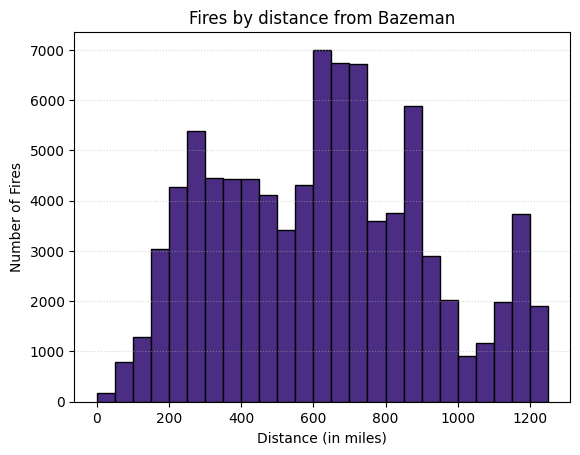

In [128]:
max_distance = 1250

# Creating distance bins for the histograms at 50 mile distances
bins = range(0, max_distance + 50, 50)
color = '#4b2e83'
plt.hist(df['Distance'], bins=bins, edgecolor='k', color=color)

# Plot parameters
plt.title('Fires by distance from Bazeman')
plt.xlabel('Distance (in miles)')
plt.ylabel('Number of Fires')
plt.grid(axis='y', linestyle='dotted', alpha=0.5)
plt.savefig('Viz1.png')
# Show the histogram
plt.show()


2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.


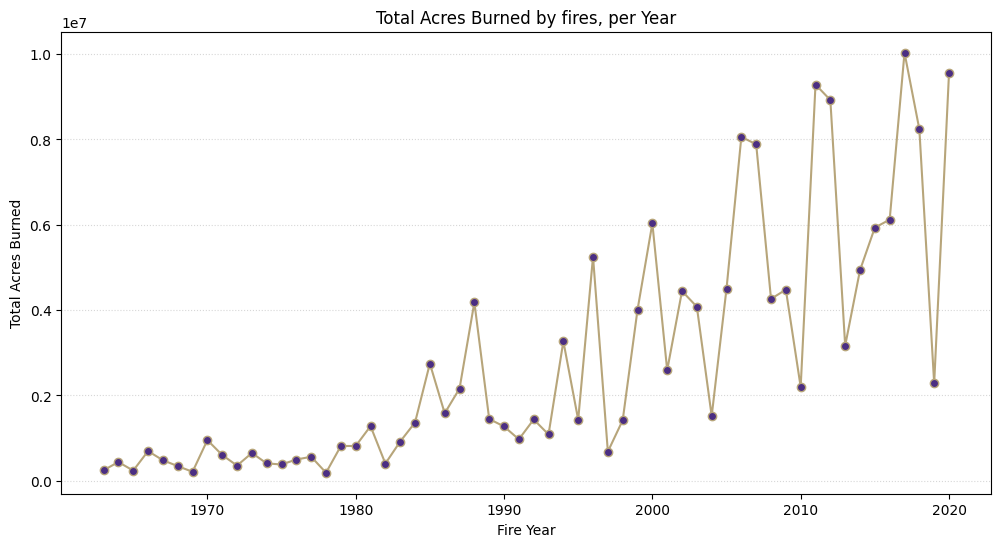

In [129]:

# Calculate total acres burned per year
total_GIS_acres_burned_per_year = df.groupby('Fire_Year')['GIS_Acres'].sum()

# time series graph
plt.figure(figsize=(12, 6))
color = '#b7a57a'
marker_color = '#4b2e83'
total_GIS_acres_burned_per_year.plot(kind='line', marker='o', color=color, markerfacecolor=marker_color)

# Customize the plot
plt.title('Total Acres Burned by fires, per Year')
plt.xlabel('Fire Year')
plt.ylabel('Total Acres Burned')
plt.grid(axis='y', linestyle='dotted', alpha=0.5)
plt.savefig('Viz2.png')
# Show the time series graph
plt.show()


3. Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.


In [116]:
# Join the 2 datasets to get AQI
viz3 = pd.merge(result, AQI_df, left_on='Fire_Year', right_on='Year', how='outer')

# Drop  duplicate columns
viz3 = viz3.drop(columns='Year')
viz3 = viz3.drop(columns='Date')
viz3['AQI'] = viz3['AQI'].fillna(0)

viz3['Date'] = pd.to_datetime(viz3['Fire_Year'], format='%Y')

# Scale the fiercity rating for better visualizationg
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 100))
viz3['Total_Fiercity_Score_for_all_fires_scaled'] = scaler.fit_transform(viz3[['Total_Fiercity_Score_for_all_fires']])

viz3.head()


,Fire_Year,Total_Fiercity_Score,Fires_this_year_2,Total_Fiercity_Score_for_all_fires,Fiercity_Rank,AQI,Date,Total_Fiercity_Score_for_all_fires_scaled
0,1963.0,2.801058,378.0,1058.8,56.0,0.0,1963-01-01,1.953143
1,1964.0,2.787139,381.0,1061.9,55.0,0.0,1964-01-01,1.988263
2,1965.0,2.677946,331.0,886.4,58.0,0.0,1965-01-01,0.000000
3,1966.0,2.847268,421.0,1198.7,53.0,0.0,1966-01-01,3.538089
4,1967.0,2.684787,447.0,1200.1,52.0,0.0,1967-01-01,3.553949


C:\Users\raman\AppData\Local\Temp\ipykernel_10536\206236263.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Viz3.png')
C:\Users\raman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


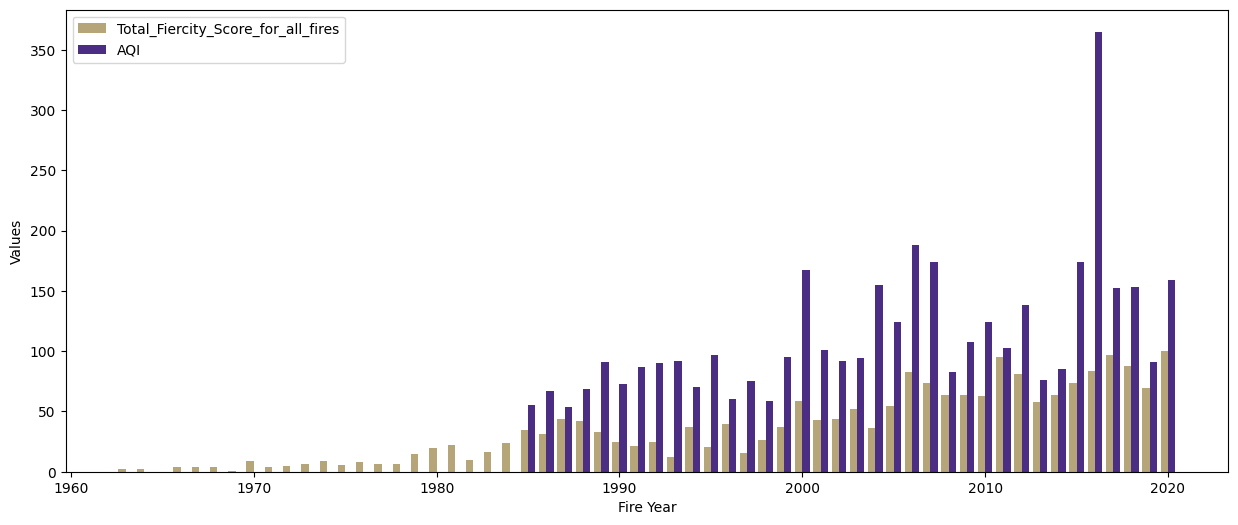

In [130]:

# Plot parameters
fig, ax = plt.subplots(figsize=(15, 6))

color1 = '#b7a57a'
color2 = '#4b2e83'

# Plot Total_Fiercity_Score_for_all_fires
ax.bar(viz3['Fire_Year'] - 0.2, viz3['Total_Fiercity_Score_for_all_fires_scaled'], width=0.4, color=color1, label='Total_Fiercity_Score_for_all_fires')

# Plot AQI
ax.bar(viz3['Fire_Year'] + 0.2, viz3['AQI'], width=0.4, color=color2,  label='AQI')

# Add labels and legend
ax.set_xlabel('Fire Year')
ax.set_ylabel('Values')
ax.legend()

plt.savefig('Viz3.png')

# Show the plot
plt.show()


## Predictions for the future


In [41]:

# Extract the input and target columns
X = result[['Fire_Year', 'Fires_this_year_2', 'Total_Fiercity_Score_for_all_fires']]
y = result['Total_Fiercity_Score']

# Create a Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict data for the years 2024-2049
future_years = range(2024, 2050)
future_data = pd.DataFrame({'Fire_Year': future_years, 'Fires_this_year_2': 0, 'Total_Fiercity_Score_for_all_fires': 0})

# Predict Total_Fiercity_Score for the future years
future_data['Predicted_Total_Fiercity_Score'] = model.predict(future_data[['Fire_Year', 'Fires_this_year_2', 'Total_Fiercity_Score_for_all_fires']])

print(future_data[['Fire_Year', 'Predicted_Total_Fiercity_Score']])


    Fire_Year  Predicted_Total_Fiercity_Score
0        2024                        2.549573
1        2025                        2.546834
2        2026                        2.544095
3        2027                        2.541356
4        2028                        2.538617
5        2029                        2.535878
6        2030                        2.533139
7        2031                        2.530400
8        2032                        2.527662
9        2033                        2.524923
10       2034                        2.522184
11       2035                        2.519445
12       2036                        2.516706
13       2037                        2.513967
14       2038                        2.511228
15       2039                        2.508489
16       2040                        2.505750
17       2041                        2.503011
18       2042                        2.500273
19       2043                        2.497534
20       2044                     

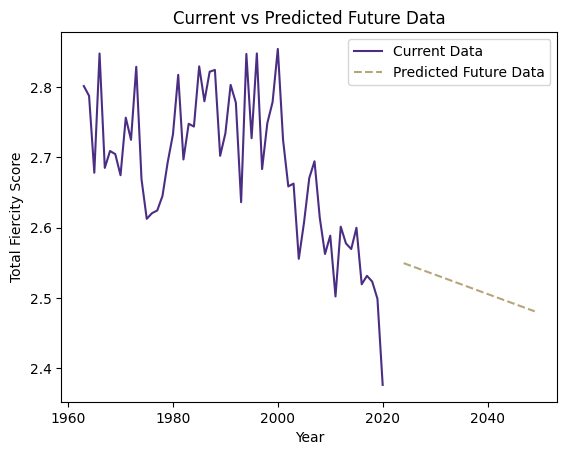

In [43]:

# Current Values
plt.plot(result['Fire_Year'], result['Total_Fiercity_Score'], label='Current Data', color='#4b2e83')

# Predicted Values
plt.plot(future_data['Fire_Year'], future_data['Predicted_Total_Fiercity_Score'], label='Predicted Future Data', linestyle='dashed', color='#b7a57a')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Total Fiercity Score')
plt.title('Current vs Predicted Future Data')

# Adding legend
plt.legend()

# Show the plot
plt.show()
